# 0. Introduction

In the last exercises, you implemented different networks for image classification on the CIFAR10 Dataset.
For this exercise you will work on pixelwise segmentation (think: classification per pixel instead of per image). 
There are multiple types of segmentation, the most prominent ones are semantic segmentation and instance segmentation.
The goal of semantic segmentation is to assign to each pixel a class (e.g. car, bike), whereas the goal of instance segmentation is to assign to each pixel some object id.
This can also be combined to e.g. extract all individual cars from an image (semantic instance segmentation).

## Grading

This exercise counts 30% towards your total score.
You can get a maximum of 100 points.

| Section | Part | Task | Points |
|------|----------------------------------------|-------------|-------------|
| 1 | Data Loader | Augmentation                             | 10          |
| 2 | U-Net | Implementation           | 30          |
| 3 | Foreground/Background Segmentation | Define U-Net instance   | 5          |
|  | | Same padding        | 5          |
| 4 |Receptive Field| Implementation                       | 10          |
| ||Question 1                                            | 5          |
| 5 | Instance Segmentation | Define losses and activations   | 10          |
| || Define U-Net instance                                |  5          | 
| || Valid padding                               |  5          | 
| ||Benchmark                                            | 10          |
| ||Question 2                                            |5          |
| |Total Points|                                            | 100          |

## General Information

**Workflow** For this assignment you need a GPU. If you have one, you can keep on working locally with this notebook. If not, we recommend to use colab. If both options do not work for you, please let us know.

**Assignment submission** You need to submit both this notebook and the model(s) you've trained. If the model is small enough you can submit it via moodle, otherwise upload it e.g. on google drive or firefox send and submit a text file with the link to it.

In [9]:
!nvidia-smi

Wed Jun 21 14:42:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.46                 Driver Version: 531.61       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090         On | 00000000:01:00.0  On |                  Off |
|  0%   43C    P8               15W / 450W|   1843MiB / 24564MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## How to setup Google Colab

You already know about colab from the previous exercises. Here are the most important infos again:

**Requirements** To use Colab, you must have a Google account with an associated Google Drive.

**Reminder** Ressources on colab are not guaranteed and therefore there might be times where some ressources cannot get allocated. If you're idle for 90 minutes or your connection time exceeds the maximum of 12 hours, the colab virtual machine will disconnect. This means that unsaved progress such as model parameters are lost.

**Upload the data**
You need to upload your data on the remote machine. Make sure to upload the zip and not the extracted data, this is significantly faster. There are two primary options:  
You can upload the data directly into colab (Click on the Files icon on the left side and then on upload). This is the most straightforward way, but you have to do it every time you start a new colab session.  
The second option is to use Google Drive and import the data from there into Colab. 
First, you need to upload the provided zip file (data.zip) to your Google Drive. Next, you mount your Google Drive on the remote machine. In order to do so, you can use the cell below.  
In all case you then have to execute the "extract data" cell to unpack the zip file (You might have to change the path_to_zip variable).  
Use the "verify" cell to make sure that the data is accessible.

In [10]:
# import os

# #### DO NOT DELETE THIS COMMENT ####
# from google.colab import drive

# ### mount your google drive
# drive.mount('/content/drive')

# # add your local project folder to be able to import all utils files
# path = "/content/drive/My Drive/Colab Notebooks/sose23" # change this to your local project folder
# os.chdir(path)

#### DO NOT DELETE THIS COMMENT ####

In [11]:
path_to_zip = "data.zip"

In [12]:
#!unzip $path_to_zip

In [13]:
# verify that the data is found
import os
import glob
fls = glob.glob(os.path.join("dsb2018", "train", "*.zarr"))
print(len(fls), fls[:5])

30 ['dsb2018/train/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339.zarr', 'dsb2018/train/0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275.zarr', 'dsb2018/train/08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada.zarr', 'dsb2018/train/1023509cf8d4c155467800f89508690be9513431992f470594281cd37dbd020d.zarr', 'dsb2018/train/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28.zarr']


## Install and import packages

In [14]:
# !pip uninstall albumentations -y
# !pip install numpy~=1.22.4 pillow~=9.1.1 matplotlib~=3.5.2 scikit-image~=0.19.2 zarr~=2.11.3 imgaug~=0.4.0 torchsummary tensorboard~=2.12.0 mahotas~=1.4.12

In [15]:
# !pip install tensorflow

In [16]:
%matplotlib inline
import datetime
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import zarr
from imgaug import augmenters as iaa
from imgaug.augmentables.heatmaps import HeatmapsOnImage
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from utils.label import PredictionType
from utils.train_val_test import (
    epoch_train_val_routine,
    step_train_val_routine,
    test_evaluation_routine,
    simple_test,
)
from utils.visualize import (
    plot_image,
    plot_random_image,
    plot_history,
    show_predictions,
    plot_receptive_field
)
from utils.disc_loss import Identity, FakeLoss


plt.rcParams['image.cmap'] = 'gist_earth'
torch.backends.cudnn.benchmark = True

# 1. Data
For this task we use a subset of the data used in the kaggle data science bowl 2018 challenge (https://www.kaggle.com/c/data-science-bowl-2018/).

## Raw Data

Example image:

![kaggle_example](https://data.broadinstitute.org/bbbc/BBBC038/BBBC038exampleimage1.png)

All images show nuclei recorded using different microscopes and lighting conditions. There are 30 images in the training set, 8 in the validation set and 16 in the test set.

Visualize the data:

Execute the next cell repeatedly to have a look at the data.
We start with the foreground/background segmentation. So the ground truth has 2 labels: Background is zero and cell is one.

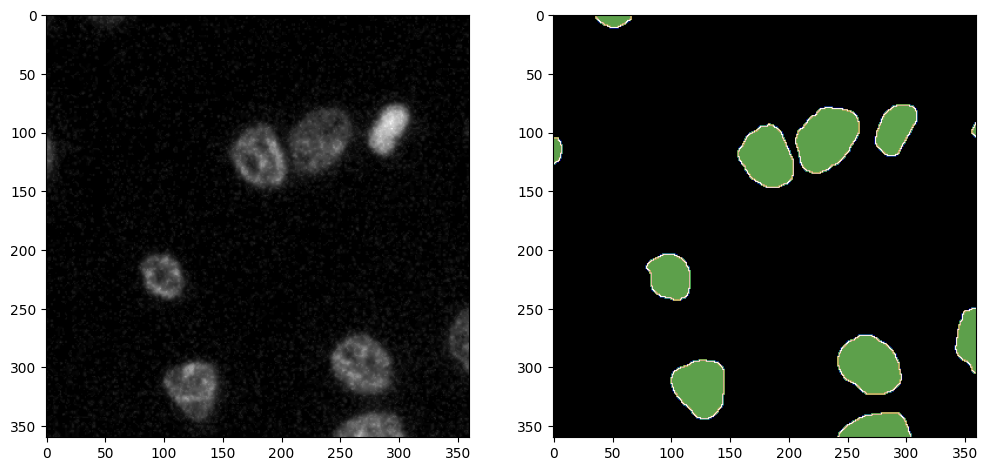

In [17]:
# repeatedly execute this cell to get different images
plot_random_image()

## Load the data

Here we implement a custom dataset for the kaggle data.
Look at the code to briefly get an understanding what happens.

For more information, you can look here:
https://pytorch.org/docs/stable/data.html
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

### Augmentation

Especially when the size of the dataset is limited, data augmentation is essential to get good results.
Extend your data loader to augment your data during training on the fly.
Think about what kind of augmentation to use (e.g. flips, rotation, elastic).

Here, we have prepared the code to use the external data augmentation library imgaug (https://imgaug.readthedocs.io/en/latest/).

In [18]:
class KaggleDSB_dataset(Dataset):
    """(subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the torch dataset class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.

    Args:
        root_dir (string):
            Directory with all the images.
        mode (string):
            train/val/test, select subset of images
        prediction_type (hpi_sose23.exercise_9.solution.utils.label.PredictionType):
            default to be "metric_learning" for this notebook
        padding_size (int):
            the number of pixels to pad on each side of the image before augmentation and cropping

    """

    def __init__(
            self,
            root_dir,
            mode,
            prediction_type,
            padding_size=None
    ):
        self.mode = mode
        self.files = glob.glob(os.path.join(root_dir, mode, "*.zarr"))
        self.prediction_type = prediction_type
        self.padding_size = padding_size
        self.define_augmentation()
        self.define_padding()

    def __len__(self):
        return len(self.files)

    def define_augmentation(self):
        """Define the augmentation pipeline for the dataset"""
        self.transform = lambda image, segmentation_maps: (image, segmentation_maps)

        ###########################################################################
        # TODO (optional): Define your augmentation pipeline.                     #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.transform = iaa.Sequential([
            iaa.Fliplr(0.5),  # Flip the image horizontally with a 50% chance
            iaa.Flipud(0.5),  # Flip the image vertically with a 50% chance
            iaa.Affine(rotate=(-90, 90)),  # Rotate the image by a random angle between -90 and 90 degrees
            iaa.GaussianBlur(sigma=(0, 1.0)),  # Apply Gaussian blur with a random sigma between 0 and 1.0
            iaa.AdditiveGaussianNoise(scale=(0, 0.001 * 255)),  # Add Gaussian noise with a random scale
            iaa.Dropout(p=(0, 0.1)),  # Randomly drop 0-10% of the pixels
            iaa.PiecewiseAffine(scale=(0.01, 0.05))  # Apply a random piecewise affine transformation
        ])


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def define_padding(self):
        """Define the padding size for the dataset."""
        self.pad = None

        ###########################################################################
        # TODO: Define the 'pad' attribute.                                       #
        #  - use imgaug to pad the image with the given padding size              #
        # Hint: We do want the shape of the image to change after padding.        #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if self.padding_size is not None:
            self.pad = iaa.Pad(px=self.padding_size, keep_size=False)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def get_filename(self, idx):
        """Get the filename of the idx-th sample

        Args:
            idx:
                The index of the sample

        Returns:
            filename (string)

        """
        return self.files[idx]

    def __getitem__(self, idx):
        fn = self.get_filename(idx)
        raw, label = self.load_sample(fn)
        raw = self.normalize(raw)

        # augment for training
        if self.padding_size is not None:
            raw = self.pad(images=raw)  # CHW -> CHW
            label = self.pad(images=label)  # CHW -> CHW

        if self.mode == "train":
            raw = np.transpose(raw, [1, 2, 0])  # CHW -> HWC
            label = np.transpose(label, [1, 2, 0])  # CHW -> HWC
            raw, label = self.augment_sample(raw, label)  # HWC -> HWC
            raw = np.transpose(raw, [2, 0, 1])  # HWC -> CHW
            label = np.transpose(label, [2, 0, 1])  # HWC -> CHW

        # put to torch tensors and return
        raw, label = torch.tensor(raw), torch.tensor(label)
        return raw, label

    def augment_sample(self, raw, label):
        """Augment a sample with the defined augmentation pipeline above.

        Args:
            raw:
                The raw image
            label:
                The label image

        Returns:
            The augmented raw and label image

        """
        # stores float label (sdt) differently than integer label (rest)
        if self.prediction_type == PredictionType.SDT:
            label = HeatmapsOnImage(label, shape=raw.shape, min_value=-1.0, max_value=1.0)
            raw, label = self.transform(image=raw, heatmaps=label)
        else:
            label = label.astype(np.int32)
            label = SegmentationMapsOnImage(label, shape=raw.shape)
            raw, label = self.transform(image=raw, segmentation_maps=label)

        label = label.get_arr()

        # some pytorch version have problems with negative indices introduced by e.g. flips: just copying fixes this
        label = label.copy()
        raw = raw.copy()

        return raw, label

    @staticmethod
    def normalize(raw):
        """Normalize the raw image to zero mean and unit variance.

        Args:
            raw:
                The raw image

        Returns:
            The normalized raw image

        """
        raw -= np.mean(raw)
        raw /= np.std(raw)
        return raw

    def load_sample(self, filename):
        """Load a sample from a zarr file depending on the prediction type.

        Args:
            filename:
                The filename of the zarr file

        Returns:
            The raw and label image

        """
        data = zarr.open(filename)
        raw = np.array(data['volumes/raw'])
        if self.prediction_type == PredictionType.TWO_CLASS:
            label = np.array(data['volumes/gt_fgbg'])
        elif self.prediction_type == PredictionType.THREE_CLASS:
            label = np.array(data['volumes/gt_threeclass'])
        elif self.prediction_type == PredictionType.AFFINITIES:
            label = np.array(data['volumes/gt_affs'])
        elif self.prediction_type == PredictionType.SDT:
            label = np.array(data['volumes/gt_tanh'])
        elif self.prediction_type == PredictionType.METRIC_LEARNING:
            label = np.array(data['volumes/gt_labels'])
        else:
            raise NotImplementedError
        label = label.astype(np.float32)
        return raw, label


### Check the data
Look at the training data to see if your dataset and data loader are working and,
if you are using augmentation, if the augmentation looks reasonable.

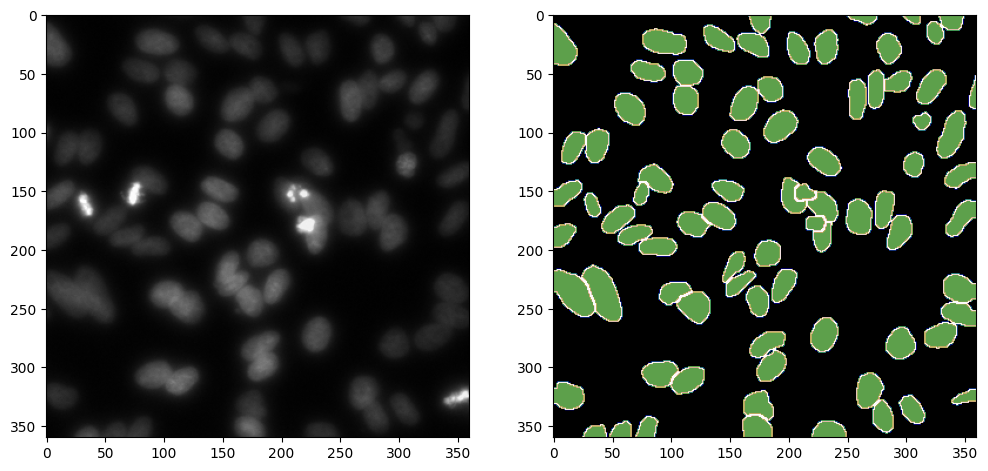

The shape of the dataset is: torch.Size([1, 360, 360])


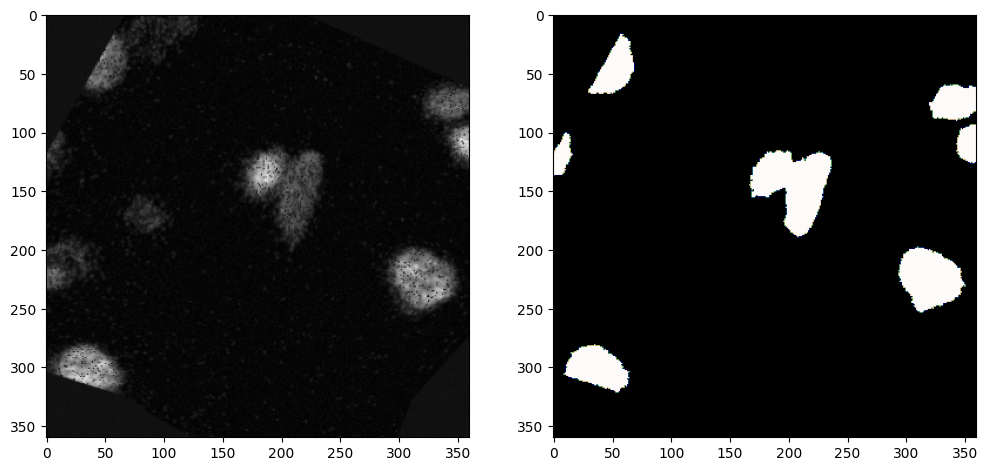

In [19]:
# lets look at our raw data
plot_random_image()

dataset = "dsb2018"
prediction_type = PredictionType.TWO_CLASS
num_fmaps_out = 2
dtype = torch.FloatTensor

# let's look at our data for the specific prediction type
tmp_data = KaggleDSB_dataset(dataset, mode="train", prediction_type=prediction_type)
tmp_loader = DataLoader(tmp_data, batch_size=1, shuffle=True)
print("The shape of the dataset is: {}".format(tmp_data[0][0].shape))

img_tmp, label_tmp = tmp_data[np.random.randint(0, len(tmp_data), 1)[0]]
plot_image(img_tmp, label_tmp, prediction_type=prediction_type)

Throughout the exercise we will deal with the following prediction Types. For now you will focus on the Two Class case.

In [20]:
print([str(x) for x in PredictionType])

['PredictionType.TWO_CLASS', 'PredictionType.THREE_CLASS', 'PredictionType.SDT', 'PredictionType.AFFINITIES', 'PredictionType.METRIC_LEARNING']


# 2. U-Net

The network you will use is a so-call U-Net. Your task is to implement it and use it to segment the dataset described above.
The U-Net is a popular core architecture for segmentation and extensively used for medical and biological data.

![unet](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Start by reading the paper: [U-Net: Convolutional Networks for BiomedicalImage Segmentation](https://arxiv.org/pdf/1505.04597.pdf). It has been hugely influential in the field and it is very concise and understandable.
We recommend asking your colleagues on the moodle forums with respect to unclear aspects of the architecture.
(If that does not solve it, there are also a number of tutorials online).

## Implementation

Your main task is to implement a U-Net yourselves. 
(Disclaimer: We are aware that there are a number of implementations out there, but we **strongly recommend** to not look at them before trying it yourselves, this is a very fundamental exercise, and the knowledge you gain will be very helpful to you if you try to implement other architectures, and you learn significantly more by trying it yourselves than by looking at other people's code.
The implementation is not completely straight forward. If you are stuck, ask in the forum or check out one of the tutorials online.
Feel free to look at the implementations **after** you have a working version and get results on the data.
It might be a helpful exercise to check what they maybe have done better and what you maybe have done better.
Yet there is no need to change your implementation, there are no extra points for the most elegant or efficient solution).

Be aware: Do not re-implement torch.nn modules. You are free to use them!

**Padding:** Both, valid or same padding should work for your convolutions.

**Upsampling**: Pytorch has modules for upsampling and transposed convolutions. Make sure both work.

In [21]:
7//2

3

In [22]:
# Be aware: Do not re-implement torch.nn modules. You are free to use them!

# **Padding:** Both, valid or same padding should work for your convolutions.

# **Upsampling**: Pytorch has modules for upsampling and transposed convolutions. Make sure both work.

class ConvPass(torch.nn.Module):
    """Convolutional pass of a U-Net."""

    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_sizes,
            padding,
            activation
    ):
        """Constructor of a convolutional pass.
        The pass consists of a series of convolutions, each followed by an activation function.

        Args:
            in_channels:
                Number of input channels
            out_channels:
                Number of output channels
            kernel_sizes:
                List of kernel sizes
            padding:
                Padding type, either 'VALID' or 'SAME'
            activation:
                Activation function, e.g. 'ReLU'
        """

        super(ConvPass, self).__init__()

        if activation is not None:
            activation = getattr(torch.nn, activation)

        ###########################################################################
        # TODO: Implement the ConvPass constructor.                               #
        # hint: You can use any (or no)  attribute that you deem usefully.        #
        # Remember to support both, 'VALID' and 'SAME' padding.                   #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Create a list of convolutional layers
        self.conv_layers = torch.nn.Sequential()

        for i, kernel_size in enumerate(kernel_sizes):
            # Create an activation map
            self.conv_layers.add_module("conv"+str(i), torch.nn.Conv2d(in_channels=in_channels,
                                                    out_channels=out_channels,
                                                    kernel_size=kernel_size,
                                                    padding=padding))
            
            # Create an activation function
            if activation is not None:
                self.conv_layers.add_module("relu"+str(i), activation()) # maybe ()?

            # Update the number of input channels
            in_channels = out_channels
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x):
        """Forward pass of the convolutional pass.

        Args:
            x:
                Input tensor

        Returns:
            Output tensor after applying the convolutional pass

        """
        c = None
        ###########################################################################
        # TODO: Implement the ConvPass forward pass.                              #
        # hint: This is not a single convolution operation!                       #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        c = self.conv_layers(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return c


class Downsample(torch.nn.Module):
    """Downsampling layer of a U-Net."""

    def __init__(
            self,
            downsample_factor
    ):
        """Constructor of a downsampling layer.

        Args:
            downsample_factor:
                Factor by which to downsample the input tensor.

        """
        super(Downsample, self).__init__()
        self.dims = len(downsample_factor)
        self.downsample_factor = downsample_factor

        ###########################################################################
        # TODO: Implement the downsample constructor.                             #
        # hint: You can use/define any (or no) attribute that you deem usefully.  #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        self.downsample = torch.nn.MaxPool2d(kernel_size=downsample_factor,
                                             stride=downsample_factor)


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x):
        """Forward pass of the downsampling layer.

        Args:
            x:
                Input tensor

        Returns:
            Output tensor after applying the downsampling layer
        """
        d = None
        #### DO NOT DELETE THIS COMMENT ####
        self.assert_downsample_factor(x)
        #### DO NOT DELETE THIS COMMENT ####

        ###########################################################################
        # TODO: Implement the downsample forward pass.                            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        d = self.downsample(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return d

    def assert_downsample_factor(self, x):
        """Assert if the downsample factor is compatible with the input tensor.

        Args:
            x:
                Input tensor

        Returns:
            True if the downsample factor is compatible with the input tensor, raises RuntimeError otherwise
        """
        for d in range(1, self.dims + 1):
            if x.size()[-d] % self.downsample_factor[-d] != 0:
                raise RuntimeError(
                    "Can not downsample shape %s with factor %s, mismatch in spatial dimension %d" % (
                        x.size(),
                        self.downsample_factor,
                        self.dims - d)
                )
        return True


class Upsample(torch.nn.Module):
    """Class that implements an upsampling layer."""

    def __init__(
            self,
            scale_factor,
            mode,
            in_channels,
            out_channels,
            padding,
    ):
        """Constructor of an upsampling layer.

        Args:
            scale_factor:
                Factor by which to upsample the input tensor
            mode:
                Upsample mode, either 'nearest' or 'transpose_conv'
            in_channels:
                Number of input channels
            out_channels:
                Number of output channels
            padding:
                Padding type, either 'VALID' or 'SAME'

        """
        super(Upsample, self).__init__()

        self.padding = padding
        self.dims = len(scale_factor)

        #############################################################################
        # TODO: Construct your Upsample object                                      #
        #  - implement both, nearest neighbor and transposed convolution upsampling #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if mode == 'nearest':
            self.upsample = torch.nn.Upsample(scale_factor=scale_factor, mode='nearest')
        elif mode == 'transpose_conv':
            if padding == 'valid':
                padding = 0
            elif padding == 'same':
                padding  = 0
            self.upsample = torch.nn.ConvTranspose2d(in_channels=in_channels,
                                                     out_channels=out_channels,
                                                     kernel_size=scale_factor,
                                                     stride=scale_factor,
                                                     padding=padding)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def center_crop(self, x, shape):
        """Center-crop x to match spatial dimensions given by shape.

        Args:
            x:
                The input tensor.
            shape:
                The target shape.

        Returns:
            The center-cropped tensor.

        """

        x_target_size = x.size()[:-self.dims] + shape

        offset = tuple(
            (a - b) // 2
            for a, b in zip(x.size(), x_target_size))

        slices = tuple(
            slice(o, o + s)
            for o, s in zip(offset, x_target_size))

        return x[slices]

    def forward(self, f_left, g_out):
        """Forward pass.

        Args:
            f_left:
                Input tensor from the left branch
            g_out:
                Input tensor from the previous layer

        Returns:
            Concatenated cropped f_left with upsampled cropped g_out

        """
        f_right = f_left  # ignore me
        ###########################################################################
        # TODO: Upsample forward pass                                             #
        # hint: You can use/define any (or no) attribute that you deem usefully.  #
        #       You can further define any function that you deem usefully.       #
        #       You should consider using the center_crop function above.         #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Crop g_out if mode nearest??
        up_g_out = self.upsample(g_out)
        f_left_crop = self.center_crop(f_left, up_g_out.shape[2:])
        f_right = torch.cat((f_left_crop, up_g_out), dim=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return f_right


class UNet(torch.nn.Module):
    """UNet class."""

    def __init__(
            self,
            in_channels,
            num_fmaps,
            fmap_inc_factors,
            downsample_factors,
            kernel_size_down,
            kernel_size_up,
            activation,
            padding,
            num_fmaps_out,
            constant_upsample
    ):
        """Unet constructor.

        Create a U-Net::

            f_in --> f_left --------------------------->> f_right--> f_out
                        |                                   ^
                        v                                   |
                     g_in --> g_left ------->> g_right --> g_out
                                 |               ^
                                 v               |
                                       ...

        where each ``-->`` is a convolution pass, each `-->>` a crop, and down
        and up arrows are max-pooling and transposed convolutions,
        respectively.

        The U-Net expects 2D tensors shaped like::

            ``(batch=1, channels, height, width)``.

        This U-Net performs only "valid" convolutions, i.e., sizes of the
        feature maps decrease after each convolution.

        Args:

            in_channels:
                The number of input channels.
            num_fmaps:
                The number of feature maps in the first layer. This is also the
                number of output feature maps. Stored in the ``channels``
                dimension.
            fmap_inc_factors:
                By how much to multiply the number of feature maps between
                layers. If layer 0 has ``k`` feature maps, layer ``l`` will
                have ``k*fmap_inc_factor**l``.
            downsample_factors:
                List of tuples ``(y, x)`` to use to down- and up-sample the
                feature maps between layers.
            kernel_size_down:
                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the left side. Kernel sizes
                can be given as tuples or integer.
            kernel_size_up:
                List of lists of kernel sizes. The number of sizes in a list
                determines the number of convolutional layers in the
                corresponding level of the build on the right side. Within one
                of the lists going from left to right. Kernel sizes can be
                given as tuples or integer.
            activation:
                Which activation to use after a convolution. Accepts the name
                of any tensorflow activation function (e.g., ``ReLU`` for
                ``torch.nn.ReLU``).
            constant_upsample:
                If set to true, perform a constant upsampling instead of a
                transposed convolution in the upsampling layers.

        """
        super(UNet, self).__init__()

        self.num_levels = len(downsample_factors) + 1
        self.in_channels = in_channels
        self.out_channels = num_fmaps_out if num_fmaps_out else num_fmaps
        self.mode = 'nearest' if constant_upsample else 'transpose_conv'
        self.kernel_size_down = kernel_size_down
        self.kernel_size_up = kernel_size_up
        self.downsample_factors = downsample_factors

        ########################################################################
        # TODO: Unet                                                           #
        # - Implement your Unet class here                                     #
        # - the l_conv, l_down, l_up and l_out attributes should gather        #
        #   the respective nn.modules of the U-Net as a nn.ModuleList!         #
        # - l_conv should contain the convolutional passes of the left branch  #
        # - l_down should contain the downsample layers of the left branch     #
        # - r_up should contain the upsample layers of the right branch        #
        # - r_conv should contain the convolutional passes of the right branch #
        # - (later) Add a function to compute its receptive field              #
        # - note:                                                              #
        #   - you can define and use any additional attribute that             #
        #     you deem usefully.                                               #
        #   - this class makes use of Upsample, Downsample and ConvPass        #
        #     objects so implement the classes first!                          #
        #   - do not force the output of this UNET to any task                 #
        #     specific putput dimension! (e.g. convolut to one output channel) #
        #   - do not hardcode the number of levels!                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.l_conv = None
        self.l_down = None
        self.r_up = None
        self.r_conv = None

        # store input, output channels for each level
        self.all_in_channels = [None] * self.num_levels
        self.all_out_channels = [None] * self.num_levels
        # left convolutional passes
        self.l_conv = nn.ModuleList([])
        for i in range(self.num_levels):
            self.l_conv.append(ConvPass(
                in_channels     = self.in_channels,
                out_channels    = num_fmaps,
                kernel_sizes     = self.kernel_size_down[i],
                activation      = activation,
                padding         = padding
            ))
            self.all_in_channels[i] = self.in_channels
            self.all_out_channels[i] = num_fmaps
            self.in_channels = num_fmaps
            num_fmaps *= fmap_inc_factors


        # left downsample layers
        self.l_down = nn.ModuleList([])
        for i in range(self.num_levels - 1):
            self.l_down.append(Downsample(
                downsample_factors[i]
            ))

        # right up/crop/concatenate layers
        self.r_up = nn.ModuleList([])
        for i in range(self.num_levels - 1):
            self.r_up.append(Upsample(
                scale_factor    = downsample_factors[-i - 1],
                mode            = self.mode,
                in_channels     = self.all_out_channels[-i - 1],
                out_channels    = self.all_in_channels[-i - 1],
                padding         = padding
            ))

        # right convolutional passes
        self.r_conv = nn.ModuleList([])
        for i in range(self.num_levels - 1):
            self.r_conv.append(ConvPass(
                in_channels     = self.all_out_channels[-i - 1],
                out_channels    = self.all_in_channels[-i - 1],
                kernel_sizes    = self.kernel_size_up[i],
                activation      = activation,
                padding         = padding
            ))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        self.weights_init()

    def weights_init(self):
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0.01)

        if isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0.01)


    def get_fov(self):
        """Compute the receptive field of the Unet."""
        fov = None
        ########################################################################
        # TODO: Field of View                                                  #
        # - Implement your Unet field of view function here                    #
        # - Hint: You can call and or define any other class functions         #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        fov = 1

        # Compute the receptive field for the left branch
        for i in range(self.num_levels):
            # Convolutional layer
            fov += (self.kernel_size_down[i][0] - 1)

            # Downsample layers
            if i < self.num_levels - 1:
                downsample_factor = self.downsample_factors[i][0]
                fov += (downsample_factor - 1) * (self.kernel_size_down[i][0] - 1)

        # Compute the receptive field for the right branch
        for i in range(self.num_levels - 1):
            # Upsample layers
            upsample_factor = self.downsample_factors[-i - 1][0]
            fov += (upsample_factor - 1) * (self.kernel_size_up[i][0] - 1)

            # Convolutional layer
            fov += (self.kernel_size_up[i][0] - 1)

        return fov
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return fov


    def forward(self, x):
        """Forward pass through the network."

        Args:
            x:
                Input tensor of shape (b, c, y, x).

        Returns:
            The feature.

        """
        y = None
        ########################################################################
        # TODO: Unet forward pass                                              #
        # - Implement your Unet forward pass                                   #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # left passes
        left_passes = [None] * self.num_levels
        for i in range(self.num_levels):
            x = self.l_conv[i](x)
            left_passes[i] = x
            if i < self.num_levels - 1:
                x = self.l_down[i](x)

        # right passes
        for i in range(self.num_levels - 1):
            x = self.r_up[i](left_passes[-i - 2], x)
            x = self.r_conv[i](x)

        y = x

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return y

# 3. Foreground Segmentation
Define your model for foreground/background segmentation and print out your network summary.

In [23]:
unet = Identity()
##########################################################################
# TODO: unet with same padding                                           #
# - now define your unet object                                          #
# - your unet should use:                                                #
#   - 1 input channel                                                    #
#   - 6 feature maps in the first layer                                  #
#   - 6 feature maps in the last layer                                   #
#   - a feature map increase factor of 2                                 #
#   - 4 downsample steps of kernel size 2x2                              #
#   - 'ReLU' activation                                                  #
#   - 'same' padding                                                     #
#   - no constant upsampling                                             #
#   - 2 convolutions per UNET Upsampling block with kernel size of 3x3   #
#   - 2 convolutions per UNET Downsampling block with kernel size of 3x3 #
##########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

number_layers = 5
unet = UNet(
    in_channels         = 1,
    num_fmaps           = 6,
    num_fmaps_out       = 6,
    fmap_inc_factors    = 2,
    downsample_factors  = [[2, 2]] * (number_layers - 1),
    activation          = 'ReLU',
    padding             = 'same',
    constant_upsample   = False,
    kernel_size_up      = [[3] * 2] * number_layers,
    kernel_size_down    = [[3] * 2] * number_layers
)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

task_head = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)  # do not take me for granted!

########################################################################
# TODO:                                                                #
# - Implement a last 2D convolution layer to get to your desired       #
#   output shape                                                       #
# - use a kernel size of 1x1, and no padding                           #
# - choose the right number of output channels for the                 #
#   TWO_CLASS classification problem                                   #
#   hint: Don't forget the bias                                        #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

task_head = torch.nn.Conv2d(in_channels=6, out_channels=1, kernel_size=1, bias=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

net = torch.nn.Sequential(
    unet,
    task_head
)

In [24]:
# print network layers
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

## Prepare the dataset for training. Choose the correct padding for your network object

In [25]:
# make datasets
dataset = "dsb2018"

padding_size_same = None
########################################################################
# TODO:                                                                #
# - choose the correct padding here.                                   #
# - hint: the dimension of the raw data can be inspected above.        #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

padding_size_same = (4, 4, 4, 4)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

data_train = KaggleDSB_dataset(dataset, "train", prediction_type=prediction_type, padding_size=padding_size_same)
data_val = KaggleDSB_dataset(dataset, "val", prediction_type=prediction_type, padding_size=padding_size_same)
data_test = KaggleDSB_dataset(dataset, "test", prediction_type=prediction_type, padding_size=padding_size_same)

# look at what the dataset returns
print('Train set size: {}'.format(len(data_train)))
print('Validation set size: {}'.format(len(data_val)))
print('Test set size: {}'.format(len(data_test)))
data_shape = data_train[0][0].shape
print('Data dimension after your padding: {}'.format(data_shape))

# Let's check our network
summary(net, torch.Size([1, 360, 360]), device="cuda")

Train set size: 30
Validation set size: 8
Test set size: 16
Data dimension after your padding: torch.Size([1, 360, 360])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 360, 360]              60
              ReLU-2          [-1, 6, 360, 360]               0
            Conv2d-3          [-1, 6, 360, 360]             330
              ReLU-4          [-1, 6, 360, 360]               0
          ConvPass-5          [-1, 6, 360, 360]               0
         MaxPool2d-6          [-1, 6, 180, 180]               0
        Downsample-7          [-1, 6, 180, 180]               0
            Conv2d-8         [-1, 12, 180, 180]             660
              ReLU-9         [-1, 12, 180, 180]               0
           Conv2d-10         [-1, 12, 180, 180]           1,308
             ReLU-11         [-1, 12, 180, 180]               0
         ConvPass-12         [-1, 12, 180, 180

In [26]:
print(net)

Sequential(
  (0): UNet(
    (l_conv): ModuleList(
      (0): ConvPass(
        (conv_layers): Sequential(
          (conv0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (relu0): ReLU()
          (conv1): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (relu1): ReLU()
        )
      )
      (1): ConvPass(
        (conv_layers): Sequential(
          (conv0): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (relu0): ReLU()
          (conv1): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (relu1): ReLU()
        )
      )
      (2): ConvPass(
        (conv_layers): Sequential(
          (conv0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (relu0): ReLU()
          (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (relu1): ReLU()
        )
      )
      (3): ConvPass(
        (conv_layers): Sequential(
          (conv0): Con

## prepare the dataloader for training and print network summary

In [27]:
# make dataloaders
batch_size = 4
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(data_val, batch_size=1, pin_memory=True)
test_loader = DataLoader(data_test, batch_size=1)

## train your network
In the training process of semantic segmentation scenario, we usally will record two basic criteria, loss and pixel accuracy.
The loss function we use here is the Binary Cross Entropy with the sigmoid function before it.
The pixel accuracy, or accuracy for short, refers to the percent of pixels in the image which were correctly classified.

In [28]:
# !pip install ipywidgets

In [29]:
# now it is time to train the network
num_epochs = 100
skip_training = True
if not skip_training:
    net, history, optimizer = epoch_train_val_routine(net, num_epochs, learning_rate=5e-4, train_loader=train_loader,
                                                    val_loader=val_loader, start_epoch=0, dtype=dtype)

In [30]:
# plot loss and accuracy
if not skip_training:
    plot_history(history)

## Test and evaluate our model

In [31]:
# plot predicted results for test data
activation_two_class = None
########################################################################
# TODO: Two Class Unet activation                                      #
# - Choose the right activation for your two class unet                #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

activation_two_class = lambda x: torch.sigmoid(x)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################
if not skip_training:
    images, labels, predictions, mean_accuracy = simple_test(net, test_loader, activation_two_class, device)
    print('Accuracy: {:.3f}'.format(mean_accuracy))

    show_predictions(images, labels, predictions)

The training of the networks depend on many hyperparameters such as
- network architecture: #layers, #fmaps
- batch size, learning rate
- number and distribution of the training samples

You can play and see how these settings influence the learning curve.

![image.png](https://drive.google.com/uc?export=view&id=18KqN2SHcjVk0EhQtG7JI8SerbpMtBldZ)

# 4. (Effective) Receptive Field of View

The number of convolutions and the depth of the U-Net are the major factors in determining the 
receptive field of the network. The term is borrowed from biology where it describes the "portion of sensory space that can elicit neuronal responses when stimulated" (wikipedia). Each output pixel can look at/depends on an input patch with that diameter centered at its position.
Based on this patch, the network has to be able to make a decision about the prediction for the respective pixel.
Yet larger sizes increase the computation time significantly.

This paper gives a short introduction into the computation: [What are the Receptive, Effective Receptive, and Projective Fields of Neurons in Convolutional Neural Networks?](https://arxiv.org/pdf/1705.07049.pdf).

For more detail you can look into [Computing Receptive Fields of Convolutional Neural Networks](https://distill.pub/2019/computing-receptive-fields/).

The effective receptive field of your network depends on the kind and number of layers.
Some layers have no impact on it, e.g. ReLu as it only works on individual pixels.
Some layers have a one-time effect on it, e.g. convolutional layers, as they work on a local patch of pixels.
A convolutional kernel with a size of 3 looks at the pixel itself and the direct neighbor on each side, it thus increases the receptive field by 2 (per dimension).
Some layers have a permanent effect on it, e.g. pooling. For example, 2x max-pooling (with a stride of two) reduces the image size by a factor of two and selects the maximum value of each block of size 2.
However, all following convolutional layers now operate on the pooled features.
Thus the pixels the kernel covers each correspond to two pixels from before the pooling layer.
A convolutional kernel with size 3 thus increases the receptive field not by 2 but by 2 * size of pooling layer * number of pooling layers before it.

Think about how the other layers in your network influence the field of view of your network.

Implement the get_fov function in your Unet implementation to compute the receptive field of your U-Net.
You might need to re-load your Unet class.

27


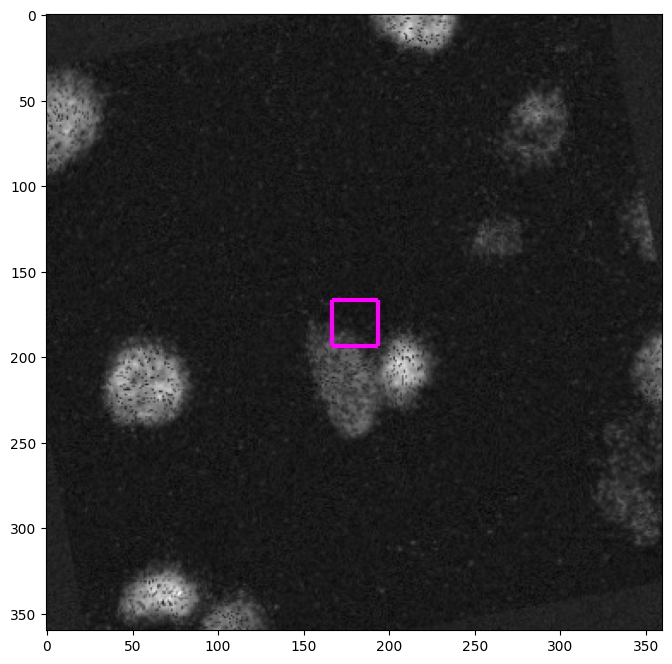

In [32]:
# visualize receptive field
dataiter = iter(tmp_loader)
inputs, labels = next(dataiter)

fov = None
fov = net[0].get_fov()
print(fov)

plot_receptive_field(inputs, fov)

## Question 1
Hypothesize shortly what receptive field sizes might make sense for the kaggle nuclei dataset and why?  
(The important part here is to think about it and come up with arguments for your theories.  
You get points even if your ideas don't apply in this case)  

################ START OF YOUR TEXT ################

It is important to have a receptive field that can tell us whether the majority of the pixels it looks at is nuclei or not. Having a receptive field that is bigger than a nuclei could thus lead to problems, while we also do not want a receptive field that does not have enough contextual information. In my opinion, something like half a nuclei in average should be a good size due to the reasons mentioned.

################ END OF YOUR TEXT ################


# 5. Instance Segmentation

So far we were only interested in classes, what is background and foreground, 
where are cells or person vs car. But in many cases we not only want to know
if a certain pixel belongs to a cell, but also to which cell.

For isolated objects, this is trivial, all connected foreground pixels form
one instance, yet often instances are very close together or even overlapping.
Then we need to think a bit more how to formulate the loss for our network
and how to extract the instances from the predictions.

## Instance segmentation approaches

There are many different approaches to instance segmentation.
We will introduce three basic methods:

### Three-class model
This is an extension of the basic foreground/background (or two-class) model.
In addition a third class is introduced: the boundary.
Even if two instances are touching, there is a boundary between them. This way they can be separated. 
Instead of a single output (where an output of zero is one class and of one is the other class), the network outputs three values, one per class. And the loss function changes from binary to (sparse) categorical cross entropy.

![three_class.png](https://drive.google.com/uc?export=view&id=1ORZTlHXJHKNFLf9U-PVraCNKLLgD-UON)

### Distance Transform
The label for each pixel is the distance to the closest boundary. 
The value within instances is negative and outside of instances is positive.
As the output is not a probability but an (in principle) unbounded scalar, the mean squared error loss function is used.

![sdt.png](https://drive.google.com/uc?export=view&id=1NucFhe9qWvj26A7R7BUQhCFsktDIZrYF)


### Edge Affinities 
Here we consider not just the pixel but also its direct neighbors (in 2D the left neighbor and the upper neighbor are sufficient, right and down are redundant with the next pixel's left and upper neighbor).
Imagine there is an edge between two pixels if they are in the same class and no edge if not. If we then take all pixels that are directly and indirectly connected by edges, we get an instance. The network predicts the probability that there is an edge, this is called affinity.
As we are considering two neighbors per pixel, our network needs two outputs and as the output is a probability, we are using binary cross entropy

![affinities.png](https://drive.google.com/uc?export=view&id=1qRxqyFLmVqDx4EP4aQPaJbLZKsaV5OLq)

### Metric Learning 
In metric learning your model learns to predict an embedding vector for each pixel. These embedding vectors are learned such that vectors from pixels belonging to the same instance are similar to each other and dissimilar to the embedding vectors of other instances and the background. It can also be thought of as learning a false coloring where each instance is colored with a unique but arbitrary color.  
![metric_learning.png](https://drive.google.com/uc?export=view&id=1ynjUUcsnADX2VltNg26RtQzLYl7S0cDQ)



## Activation and loss functions
We have 5 types of labels, corresponding to 5 **prediction_types** below.

For each case, we should define the corresponding output channel numbers, final activation layer, criterion(loss function) and dtye(the data type of the label).It would be clear to fill in these conditions after you look through the part of code about how we define training process.

Please fill in the missing code and uncomment one of the **prediction_type** to start your training. Please consider the discriminative loss from utils for the metric learning approach.

In [33]:
def get_instance_segmentation_types(prediction_type):
    from utils.disc_loss import DiscriminativeLoss
    ########################################################################
    # TODO: segmentation types                                             #
    # - Fill in the correct number of out_channels, activation,            #
    # loss function, and dtype for the corresponding PredictionType        #
    ########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    if prediction_type == PredictionType.TWO_CLASS:
        out_channels = 1
        activation = torch.nn.Sigmoid()
        loss_fn = torch.nn.BCELoss()
        dtype = torch.LongTensor
    elif prediction_type == PredictionType.THREE_CLASS:
        out_channels = 3
        activation = torch.nn.Softmax(dim=1)
        loss_fn = torch.nn.CrossEntropyLoss()
        dtype = torch.LongTensor
    elif prediction_type == PredictionType.AFFINITIES:
        out_channels = 2
        activation = torch.nn.Softmax(dim=1)
        loss_fn = torch.nn.CrossEntropyLoss()
        dtype = torch.FloatTensor
    elif prediction_type == PredictionType.SDT:
        out_channels = 2
        activation = torch.nn.Softmax(dim=1)
        loss_fn = torch.nn.MSELoss()
        dtype = torch.FloatTensor
    elif prediction_type == PredictionType.METRIC_LEARNING:
        out_channels = 2
        activation = torch.nn.Softmax(dim=1)
        loss_fn = DiscriminativeLoss(delta_dist=1.5, device=device)
        dtype = torch.LongTensor
    else:
        raise RuntimeError("invalid prediction type")

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################
    return out_channels, activation, loss_fn, dtype


In [34]:
########################################################################
# TODO (later) - first reach the evaluation task - evaluation:         #
# - enable different Prediction Types other than THREE_CLASS           #
#    and compare the evaluation performance                            #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# prediction_type = PredictionType.THREE_CLASS
prediction_type = PredictionType.AFFINITIES
# prediction_type = PredictionType.SDT
# prediction_type = PredictionType.METRIC_LEARNING

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

out_channels, activation, loss_fn, dtype = get_instance_segmentation_types(prediction_type)

## Define our U-Net for instance segmentation

As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution.

In [40]:

unet = Identity()
##########################################################################
# TODO: unet with valid padding                                          #
# - your unet should use:                                                #
#   - 1 input channel                                                    #
#   - 32 feature maps in the first layer                                 #
#   - 32 feature maps in the last layer                                  #
#   - a feature map increase factor of 2                                 #
#   - 3 downsample steps of kernel size 2x2                              #
#   - 'ReLU' activation                                                  #
#   - 'valid' padding                                                    #
#   - no constant upsampling                                             #
#   - 2 convolutions per UNET Upsampling block with kernel size of 3x3   #
#   - 2 convolutions per UNET Downsampling block with kernel size of 3x3 #
##########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

number_layers = 4
unet = UNet(
    in_channels         = 1,
    num_fmaps           = 32,
    num_fmaps_out       = 32,
    fmap_inc_factors    = 2,
    downsample_factors  = [[2, 2]] * (number_layers - 1),
    activation          = 'ReLU',
    padding             = 'valid',
    constant_upsample   = False,
    kernel_size_up      = [[3] * 2] * number_layers,
    kernel_size_down    = [[3] * 2] * number_layers
)
            

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

task_head = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)  # do not take me for granted!

########################################################################
# TODO: task head                                                      #
# - Implement a last 2D convolution layer to get to your desired       #
#   output shape                                                       #
# - use a kernel size of 1x1, and no padding                           #
# - use the output_channel from the get_instance_segmentation_types    #
#   function                                                           #
#   hint: Don't forget the bias                                        #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

task_head = torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1, bias=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

net = torch.nn.Sequential(
    unet,
    task_head
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

## prepare the data for training

In [49]:
padding_size_valid = None
########################################################################
# TODO: valid padding                                                  #
# - Choose the right padding for your valid padded unet                #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Input dimension: 360x360
padding_size_valid = 2

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

data_train = KaggleDSB_dataset(dataset, "train", prediction_type=prediction_type, padding_size=padding_size_valid)
data_val = KaggleDSB_dataset(dataset, "val", prediction_type=prediction_type, padding_size=padding_size_valid)
data_test = KaggleDSB_dataset(dataset, "test", prediction_type=prediction_type, padding_size=padding_size_valid)

# look at what the dataset returns
print('Train set size: {}'.format(len(data_train)))
print('Validation set size: {}'.format(len(data_val)))
print('Test set size: {}'.format(len(data_test)))
data_shape = data_train[0][0].shape
print('Data dimension after padding: {}'.format(data_shape))

Train set size: 30
Validation set size: 8
Test set size: 16
Data dimension after padding: torch.Size([1, 364, 364])


In [42]:
# check if your network produces the expected output
summary(net, data_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 362, 362]             320
              ReLU-2         [-1, 32, 362, 362]               0
            Conv2d-3         [-1, 32, 360, 360]           9,248
              ReLU-4         [-1, 32, 360, 360]               0
          ConvPass-5         [-1, 32, 360, 360]               0
         MaxPool2d-6         [-1, 32, 180, 180]               0
        Downsample-7         [-1, 32, 180, 180]               0
            Conv2d-8         [-1, 64, 178, 178]          18,496
              ReLU-9         [-1, 64, 178, 178]               0
           Conv2d-10         [-1, 64, 176, 176]          36,928
             ReLU-11         [-1, 64, 176, 176]               0
         ConvPass-12         [-1, 64, 176, 176]               0
        MaxPool2d-13           [-1, 64, 88, 88]               0
       Downsample-14           [-1, 64,

## prepare the dataloader

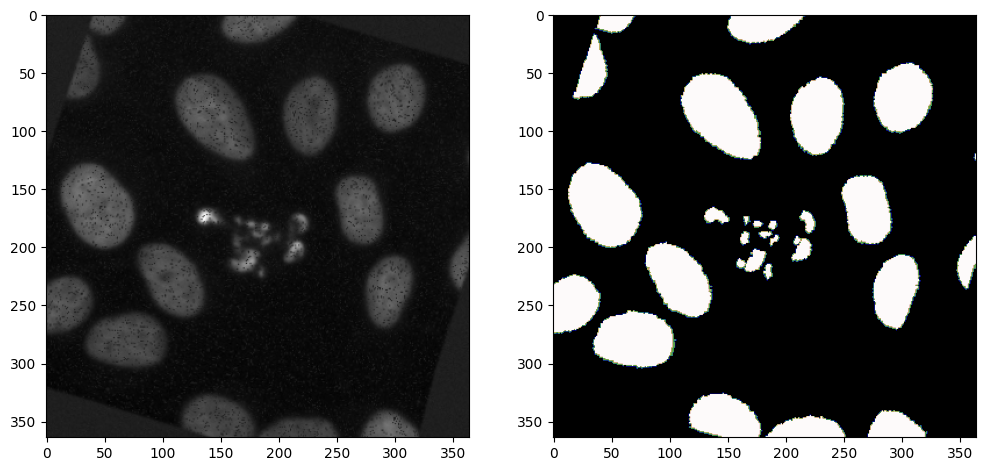

In [43]:
# re-define your dataloaders
batch_size = 4
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(data_val, batch_size=1, pin_memory=True)
test_loader = DataLoader(data_test, batch_size=1)

img_tmp, label_tmp = data_train[np.random.randint(0, len(data_train), 1)[0]]
plot_image(img_tmp, label_tmp, prediction_type=prediction_type)


## train the instance segmentation network

Before we start training, we have to compile the network and set the optimizer (try playing with the learning rate, a higher learning rate can lead to faster training, but also to divergence or lower performance).

To visualize our results we now use Tensorboard. This is a very useful extension for your browser that let's you look into networks computational graph and the weights and metrics over time.

In [44]:
training_steps = 2000  # feel free to change me
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss_fn = loss_fn.to(device)
# set optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# set flags
net.train()
loss_fn.train()
step = 0

step_train_val_routine(net, train_loader, val_loader, training_steps, optimizer, loss_fn, writer, prediction_type,
                       device, dtype=dtype)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
!pip install tensorboard

In [ ]:
!kill 4901

In [46]:
%reload_ext tensorboard
%tensorboard --logdir logs

#or run:
!tensorboard --logdir=runs 
#to view in separate window

Reusing TensorBoard on port 6006 (pid 6448), started 0:00:09 ago. (Use '!kill 6448' to kill it.)

2023-06-21 15:17:27.553871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-21 15:17:28.010850: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E0621 15:17:28.036765 139796489144128 application.py:125] Failed to load plugin WhatIfToolPluginLoader.load; ignoring it.
Traceback (most recent call last):
  File "/home/jerome/anaconda3/envs/umlia23/lib/python3.9/site-packages/tensorboard/backend/application.py", line 123, in TensorBoa

## Postprocessing

In contrast to the semantic segmentation the postprocessing to extract the final segmentation is a bit more involved and consists of x steps for the two class, three class, sdt and affinity models:
- based on the prediction we define a surface
- we extract the maxima from this surface
- we use the maxima as seeds in an off-the-shelf watershed algorithm
- and mask the result with the foreground.
The foreground areas covered by the watershed from each seed point correspond to the instances.
The resulting instances are then matched to the ground truth instances (at least 50% overlap) to get our final score (averaged over all instances and all test images)

For the metric learning model, the post-processing is a bit different. The embeddings are clustered with the mean shift algorithm and the clusters are numbered. You can think of this as clustering pixels by their color, such that the pixels that belong to one uniquely colored instance end up in one cluster and get the same number assigned.

## Class-intern benchmark
Try different methods, hyperparameters, padding,network sizes, etc. and see how you can improve your results. Write down your best average precision on the test set with the corresponding network settings.


################ START OF YOUR TEXT ################

################ END OF YOUR TEXT ################

In [53]:
!pip install mahotas

In [57]:
import mahotas
########################################################################
# TODO: evaluation                                                     #
# - Tune the thresholds of the preprocessing routine for               #
# each prediction type                                                 #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# thresholds have to be tuned after training on the validation set
if prediction_type == PredictionType.TWO_CLASS:
    fg_thresh = 0.5
    seed_thresh = 0.5
elif prediction_type == PredictionType.THREE_CLASS:
    fg_thresh = 0.5
    seed_thresh = 0.5
elif prediction_type == PredictionType.SDT:
    fg_thresh = 0.5
    seed_thresh = 0
elif prediction_type == PredictionType.AFFINITIES:
    fg_thresh = 0.5
    seed_thresh = 0.5
elif prediction_type == PredictionType.METRIC_LEARNING:
    fg_thresh = 0.5
    seed_thresh = None
else:
    raise ValueError("Unknown prediction type")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

test_evaluation_routine(net, test_loader, device, prediction_type, fg_thresh, seed_thresh, padding_size_valid, data_test)

AttributeError: module 'mahotas' has no attribute 'cwatershed'

## Question 2 

Do you have further ideas how to improve our instance segmentation approach (e.g. with changes regarding to architecture, loss, etc.)?


################ START OF YOUR TEXT ################

################ END OF YOUR TEXT ################